<a href="https://colab.research.google.com/github/nadhimmna/Tugas-Machine-Learning/blob/main/UTS/UTS_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Nama       : Muhammad Nadhim Abdirrahman
* NIM        : 1103210018
* Dataset    : Credit score classification.csv
* Model      : Random Forest

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from imblearn.over_sampling import SMOTE
import warnings

# Mounting google colab dengan google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url = "/content/drive/MyDrive/Machine Learning/Datasets/train.csv"
train = pd.read_csv(url)
train.head()

<ipython-input-230-26d536a60e8e>:2: DtypeWarning:

Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.



,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [ ]:
# Age / Loans / Delayed Payments
train['Age'] = train['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
train['Num_of_Loan'] = train['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
train['Num_of_Delayed_Payment'] = train['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

# Annual Income
train['Annual_Income'] = train['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
train['Annual_Income'] = train['Annual_Income'].astype(float)

# Credit Limit
train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].replace('_', np.nan)
train['Changed_Credit_Limit'] = pd.to_numeric(train['Changed_Credit_Limit'], errors='coerce')
train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].fillna(0)

# Outstanding Debt
train['Outstanding_Debt'] = train['Outstanding_Debt'].astype(str)
train['Outstanding_Debt'] = train['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
train['Outstanding_Debt'] = pd.to_numeric(train['Outstanding_Debt'], errors='coerce')
train['Outstanding_Debt'] = train['Outstanding_Debt'].fillna(0)

# Invested Monthly
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].astype(str)
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].replace('', '0')
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
train['Amount_invested_monthly'] = pd.to_numeric(train['Amount_invested_monthly'], errors='coerce')
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].fillna(0)

# Monthly Balance
train['Monthly_Balance'] = train['Monthly_Balance'].astype(str)
train['Monthly_Balance'] = train['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
train['Monthly_Balance'] = pd.to_numeric(train['Monthly_Balance'], errors='coerce')
train['Monthly_Balance'] = train['Monthly_Balance'].fillna(0)

# Credit History Age
def parse_years_and_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0'
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0

train['Credit_History_Age_Months'] = train['Credit_History_Age'].apply(parse_years_and_months)


In [ ]:
# Duplicates
duplicates = train[train.duplicated()]
num_duplicates = duplicates.shape[0]

if num_duplicates == 0:
    print("There are no duplicates")
else:
    print("There are", num_duplicates, "duplicates.")

There are no duplicates


In [ ]:
# Data Scaling
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,119.509700,6.847573e+02,14.000000,25.000000,34.000000,42.000000,8.698000e+03
Annual_Income,100000.0,176415.701298,1.429618e+06,7005.930000,19457.500000,37578.610000,72790.920000,2.419806e+07
Monthly_Inhand_Salary,84998.0,4194.170850,3.183686e+03,303.645417,1625.568229,3093.745000,5957.448333,1.520463e+04
Num_Bank_Accounts,100000.0,17.091280,1.174048e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,100000.0,22.474430,1.290574e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,100000.0,72.466040,4.664226e+02,1.000000,8.000000,13.000000,20.000000,5.797000e+03
Num_of_Loan,100000.0,10.761960,6.178993e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
Delay_from_due_date,100000.0,21.068780,1.486010e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,100000.0,28.779410,2.181148e+02,0.000000,8.000000,13.000000,18.000000,4.397000e+03
Changed_Credit_Limit,100000.0,10.171791,6.880628e+00,-6.490000,4.970000,9.250000,14.660000,3.697000e+01


In [ ]:
selected_columns_train = train[['Num_Bank_Accounts', 'Interest_Rate', 'Annual_Income', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Total_EMI_per_month', 'Num_of_Loan', 'Num_Credit_Card']]

percentile_threshold = 0.98
percentiles = selected_columns_train.quantile(percentile_threshold)

for column in selected_columns_train.columns:
    train = train[train[column] <= percentiles[column]]

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,85806.0,120.486003,690.067511,14.000000,25.000000,34.000000,42.000000,8698.000000
Annual_Income,85806.0,49378.620726,36478.390299,7005.930000,19294.460000,36780.030000,70825.760000,166837.640000
Monthly_Inhand_Salary,72894.0,4105.781241,3036.319177,303.645417,1623.778333,3069.091667,5899.970000,14131.123333
Num_Bank_Accounts,85806.0,5.372759,2.585031,-1.000000,3.000000,6.000000,7.000000,10.000000
Num_Credit_Card,85806.0,5.779048,5.727016,0.000000,4.000000,5.000000,7.000000,171.000000
Interest_Rate,85806.0,14.551174,8.824173,1.000000,7.000000,13.000000,20.000000,128.000000
Num_of_Loan,85806.0,7.318381,18.881665,0.000000,2.000000,3.000000,6.000000,100.000000
Delay_from_due_date,85806.0,21.033483,14.786223,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_of_Delayed_Payment,85806.0,12.348321,6.845002,0.000000,8.000000,13.000000,18.000000,25.000000
Changed_Credit_Limit,85806.0,10.189597,6.867078,-6.490000,4.990000,9.280000,14.710000,36.970000


In [ ]:
# Data Entry Plus

#Filtering Trash
train = train[train['Payment_Behaviour'] != '!@9#%8']
train = train[train['Occupation'] != '_______']
print(train['Occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


In [ ]:
train = train[train['Credit_Mix'] != '_']
print(train['Credit_Mix'].unique())


['Good' 'Standard' 'Bad']


In [ ]:
selected_columns = ['Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Bank_Accounts']

for column in selected_columns:
    train = train[train[column] >= 0]

In [ ]:
# Dropping Columns
columns_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Credit_History_Age','Monthly_Inhand_Salary', 'Type_of_Loan']

train.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# Missing Values
total_missing_values = train.isnull().sum().sum()

if total_missing_values == 0:
    print("There are no missing values")
else:
    print("Total missing values:", total_missing_values)

There are no missing values


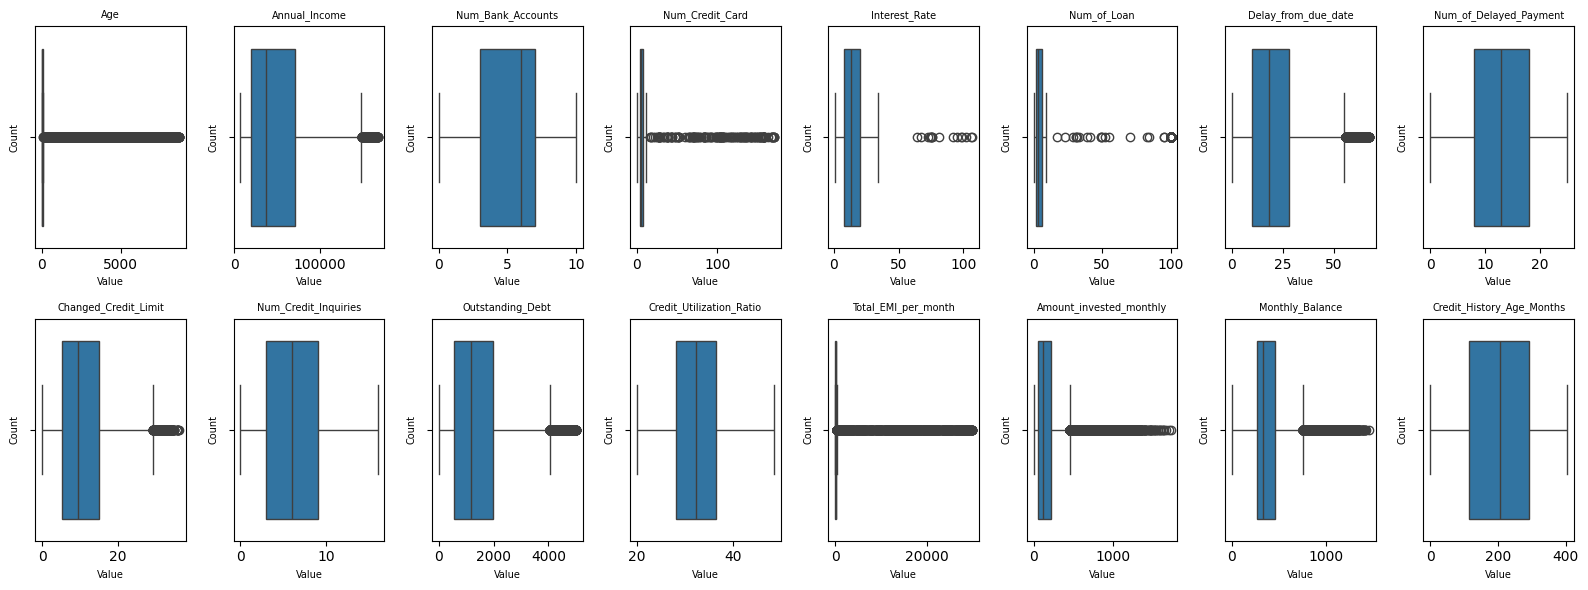

In [ ]:
# Feature Engineering
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns

num_columns = 8
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 6))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=train[column], ax=axes[i])
    axes[i].set_title(column, fontsize=7)
    axes[i].set_xlabel('Value', fontsize=7)
    axes[i].set_ylabel('Count', fontsize=7)

for j in range(len(numeric_columns), num_columns*num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Scaling 2.0
train = train[train['Age'] < 60]
train = train[train['Num_Credit_Card'] <= 10]
train = train[train['Interest_Rate'] <= 50]
train = train[train['Num_of_Loan'] <= 12]
train = train[train['Num_Bank_Accounts'] <= 10]
train = train[train['Delay_from_due_date'] <= 60]
train = train[train['Changed_Credit_Limit'] <= 30]
train = train[train['Num_Credit_Inquiries'] <= 12]
train = train[train['Total_EMI_per_month'] <= 200]
train = train[train['Outstanding_Debt'] <= 1500]

In [ ]:
# Encoding

# Label Encoder
categories = ['Poor', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[categories])
train['Credit_Score_Encoded'] = encoder.fit_transform(train[['Credit_Score']])

label_encoder = LabelEncoder()
train['Occupation_Encoded'] = label_encoder.fit_transform(train['Occupation'])

# Ordinal Encoder
categories = ['Bad', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[categories])
train['Credit_Mix_Encoded'] = encoder.fit_transform(train[['Credit_Mix']])

categories_payment_behaviour = [
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments'
]

encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])

train['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(train[['Payment_Behaviour']])

columns_to_drop = [ 'Payment_Behaviour', 'Credit_Mix', 'Occupation','Credit_Score']
train.drop(columns=columns_to_drop, inplace=True)

In [ ]:
# New Features
train['Total_Num_Accounts'] = train['Num_Bank_Accounts'] + train['Num_Credit_Card']
train['Debt_Per_Account'] = train['Outstanding_Debt'] / train['Total_Num_Accounts']
train['Debt_to_Income_Ratio'] = train['Outstanding_Debt'] / train['Annual_Income']
train['Delayed_Payments_Per_Account'] = train['Num_of_Delayed_Payment'] / train['Total_Num_Accounts']
train['Total_Monthly_Expenses'] = train['Total_EMI_per_month'] + train['Amount_invested_monthly']

In [ ]:
# Mutual Information Score (MI Score)
categorical_columns = train.select_dtypes(include=['object']).columns
data_encoded = train.copy()

encoder = OrdinalEncoder()
data_encoded[categorical_columns] = encoder.fit_transform(data_encoded[categorical_columns])

y = data_encoded['Credit_Score_Encoded']
X = data_encoded.drop(columns=['Credit_Score_Encoded'])

mi_scores = mutual_info_classif(X, y)

for i, score in enumerate(mi_scores):
    print(f"Feature '{X.columns[i]}': Mutual Information Score = {score}")

Feature 'Age': Mutual Information Score = 0.012175138580192035
Feature 'Annual_Income': Mutual Information Score = 0.42886325357298527
Feature 'Num_Bank_Accounts': Mutual Information Score = 0.05898170204598108
Feature 'Num_Credit_Card': Mutual Information Score = 0.0693142341273143
Feature 'Interest_Rate': Mutual Information Score = 0.10086515124411921
Feature 'Num_of_Loan': Mutual Information Score = 0.019297908773571848
Feature 'Delay_from_due_date': Mutual Information Score = 0.06888506649082338
Feature 'Num_of_Delayed_Payment': Mutual Information Score = 0.050358653747355264
Feature 'Changed_Credit_Limit': Mutual Information Score = 0.10329407718191441
Feature 'Num_Credit_Inquiries': Mutual Information Score = 0.02341231233482599
Feature 'Outstanding_Debt': Mutual Information Score = 0.4297593617345701
Feature 'Credit_Utilization_Ratio': Mutual Information Score = 0.0008940600062685711
Feature 'Payment_of_Min_Amount': Mutual Information Score = 0.06725743450517108
Feature 'Total_E

In [ ]:
sorted_mi_scores = sorted(zip(X.columns, mi_scores), key=lambda x: x[1], reverse=True)
sorted_columns = [x[0] for x in sorted_mi_scores]
sorted_scores = [x[1] for x in sorted_mi_scores]

colorscale = 'Viridis'

fig = go.Figure(data=[go.Bar(x=sorted_columns, y=sorted_scores, marker=dict(color=sorted_scores, colorbar=dict(title='Mutual Information Score', len=0.5, y=0.2)))])

fig.update_layout(title='Mutual Information Scores for Each Feature',
                  xaxis_title='Features',
                  yaxis_title='Mutual Information Score')

fig.show()

In [ ]:
columns_to_drop = [ 'Payment_of_Min_Amount', 'Age', 'Monthly_Balance', 'Total_Monthly_Expenses', 'Payment_Behaviour_Encoded', 'Amount_invested_monthly', 'Credit_Utilization_Ratio', 'Occupation_Encoded']
train.drop(columns=columns_to_drop, inplace=True)

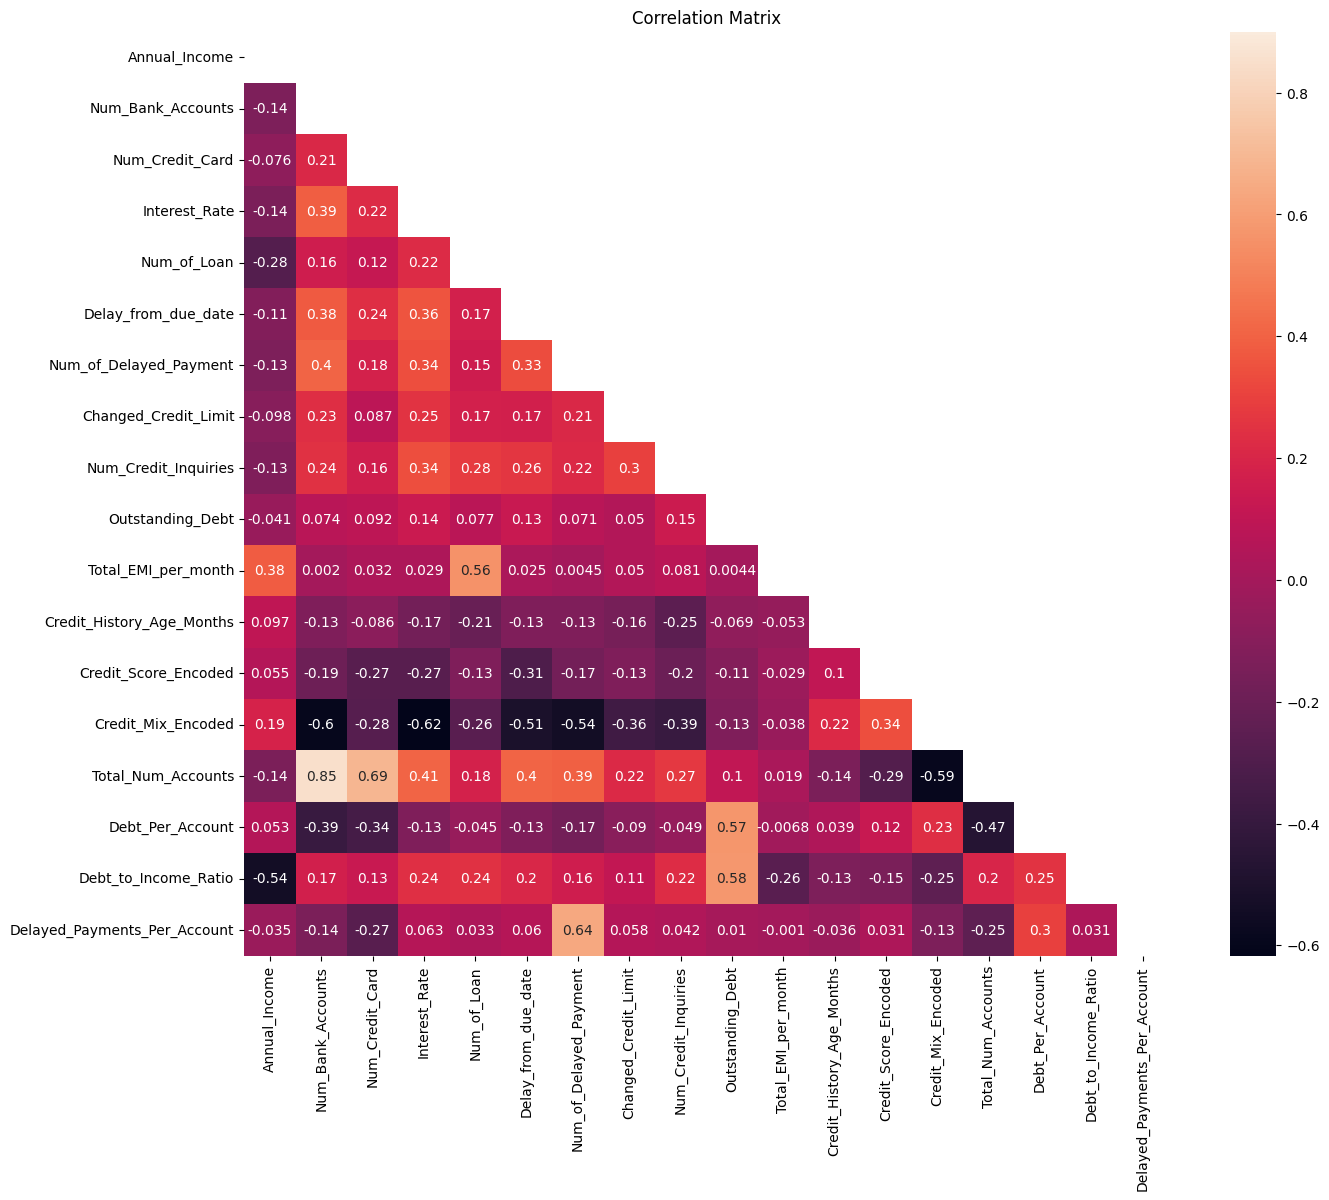

In [ ]:
# EDA

# Correlation Matrix
corr = train.select_dtypes(include=['float64', 'int64']).corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(corr, mask=mask, vmax=0.9, square=True, annot=True)
plt.title('Correlation Matrix')
plt.show()

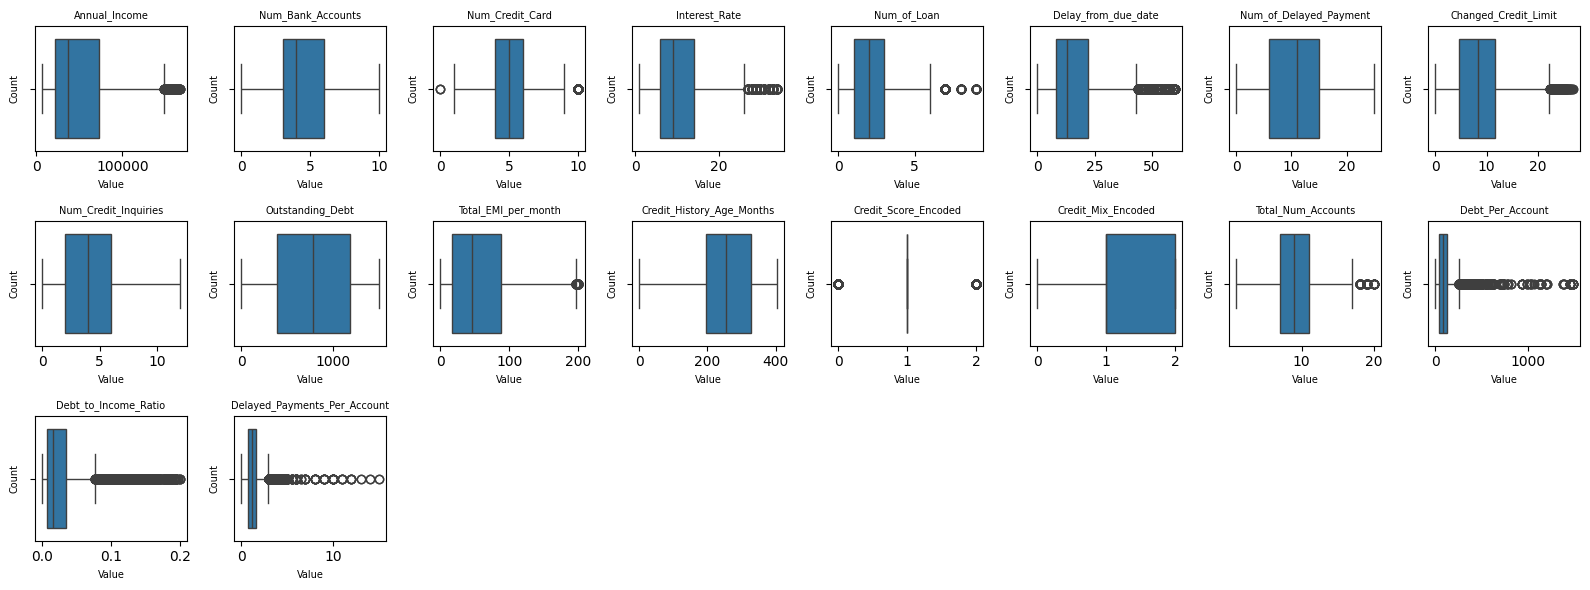

In [ ]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns

num_columns = 8
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 6))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=train[column], ax=axes[i])
    axes[i].set_title(column, fontsize=7)
    axes[i].set_xlabel('Value', fontsize=7)
    axes[i].set_ylabel('Count', fontsize=7)

for j in range(len(numeric_columns), num_columns*num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Building a Model
y = train['Credit_Score_Encoded']

X = train[['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Credit_History_Age_Months', 'Credit_Mix_Encoded', 'Total_Num_Accounts',
       'Debt_Per_Account', 'Debt_to_Income_Ratio', 'Delayed_Payments_Per_Account']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

In [ ]:
# Random Forest
model = RandomForestRegressor(n_estimators=500, bootstrap=True, random_state=77)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=77)

In [ ]:
# Model Validation (MSE)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1621489922101923


In [ ]:
smote_params = {
    'sampling_strategy': 'auto',
    'random_state': 77,
    'k_neighbors': 5,
    'n_jobs': -1
}

smote = SMOTE(**smote_params)

X_train = train.drop('Credit_Score_Encoded', axis=1)
y_train = train['Credit_Score_Encoded']

X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.15, random_state=77)

rf_classifier = RandomForestClassifier(n_estimators=500, bootstrap=True)

rf_classifier.fit(X_train_smote, y_train_smote)

print("Accuracy on training set:", rf_classifier.score(X_train_smote, y_train_smote))

y_pred_smote = rf_classifier.predict(X_test_smote)
accuracy_smote = accuracy_score(y_test_smote, y_pred_smote)

print("Accuracy on SMOTE test set:", accuracy_smote)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning:

The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.



Accuracy on training set: 0.9995520990268333
Accuracy on SMOTE test set: 0.8943239501615136


Accuracy on original test set: 0.9697313046293299

Classification report for SMOTE test set:
               precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      2919
         1.0       0.88      0.84      0.86      2871
         2.0       0.89      0.91      0.90      2878

    accuracy                           0.89      8668
   macro avg       0.89      0.89      0.89      8668
weighted avg       0.89      0.89      0.89      8668


Classification report for original test set:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       901
         1.0       0.99      0.97      0.98      3810
         2.0       0.95      0.98      0.96      1467

    accuracy                           0.97      6178
   macro avg       0.96      0.97      0.97      6178
weighted avg       0.97      0.97      0.97      6178



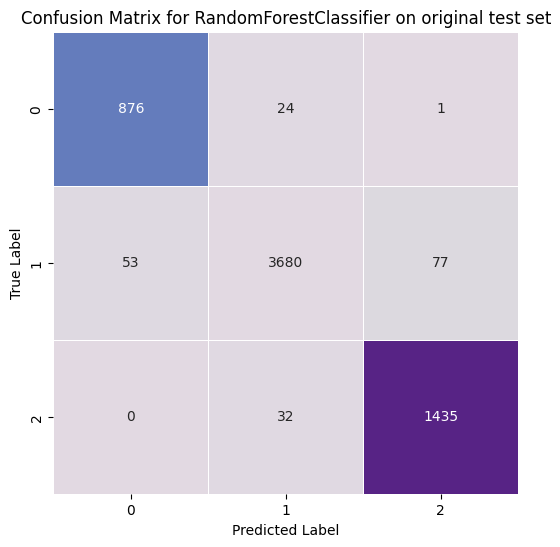

In [ ]:
# Accuracy
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on original test set:", accuracy)

matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(matrix, annot=True, cbar=False, cmap='twilight', linewidth=0.5, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for RandomForestClassifier on original test set')

print('\nClassification report for SMOTE test set:\n', classification_report(y_test_smote, y_pred_smote))
print('\nClassification report for original test set:\n', classification_report(y_test, y_pred))